In [1]:
import wandb

wandb.login(key="44daaf6b1965b2227ce6f400dfd87ca9e6d79b51")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: picklemaster (picklemasters) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from argparse import Namespace



csv_path = "https://raw.githubusercontent.com/marekfejda/ZNEUS_data/refs/heads/main/phpSSK7iA.csv"

df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()

Shape: (3751, 1777)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776,target
0,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, D1 to target
dtypes: float64(1776), int64(1)
memory usage: 50.9 MB

Columns with missing values or unexpected types
No missing-value columns found.

--- Columns with unexpected types ---
target int64
Unique values for target: [1 0]

Counts per value:
  1: 2034
  0: 1717

Proportion per value:
  1: 54.23%
  0: 45.77%


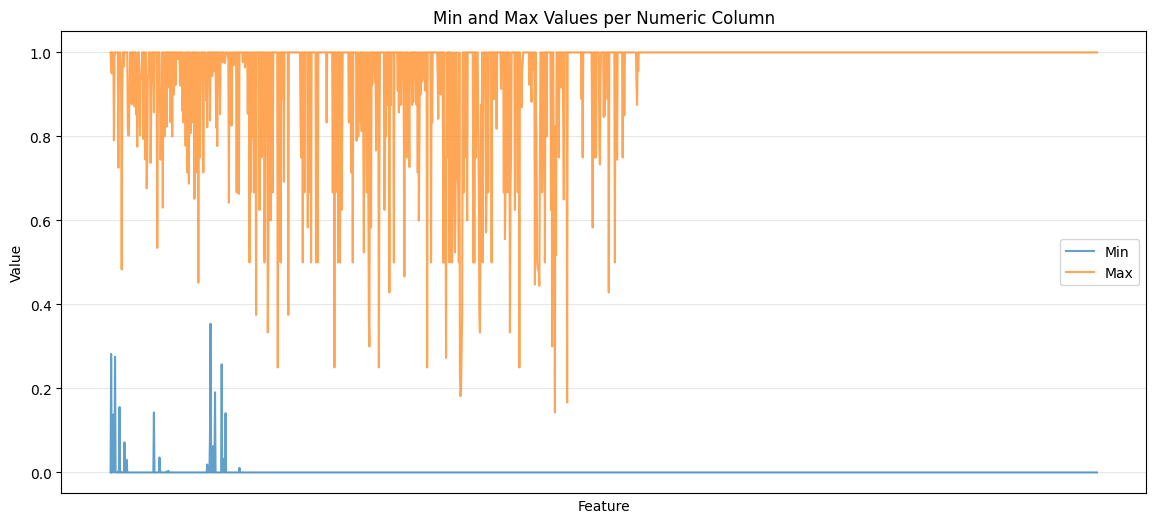

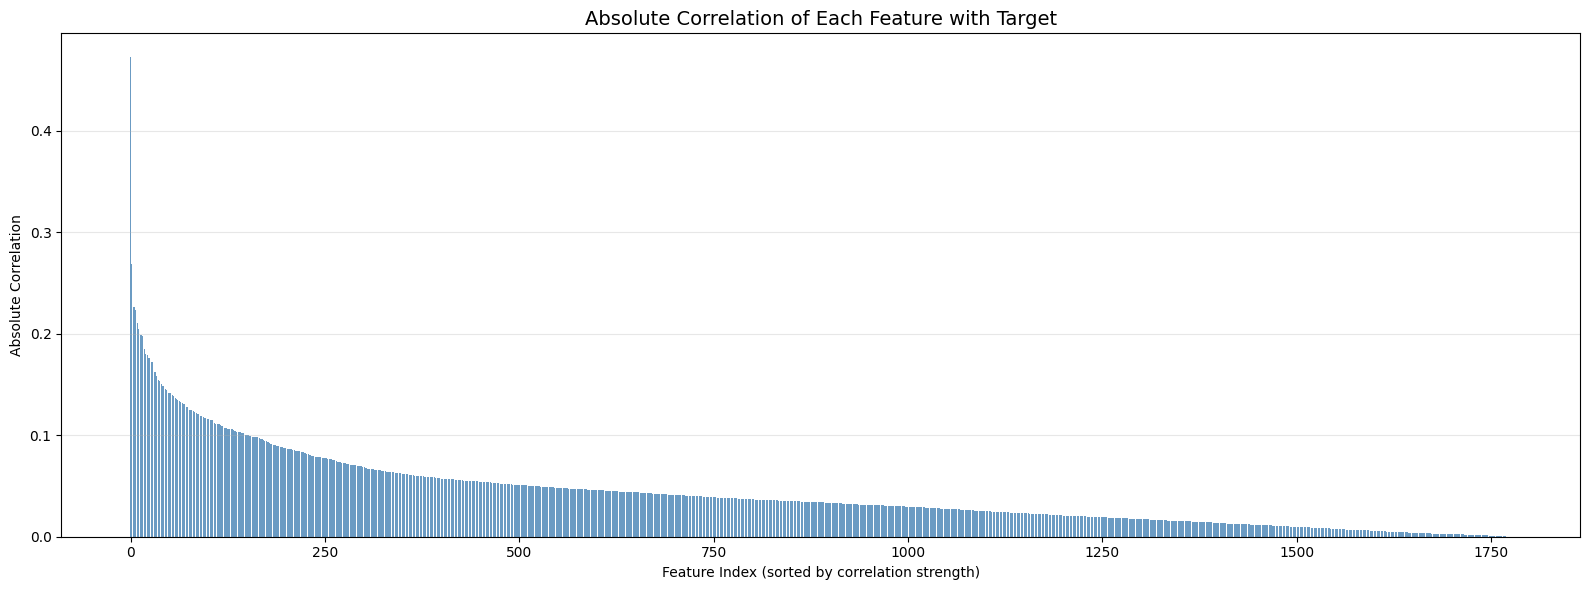

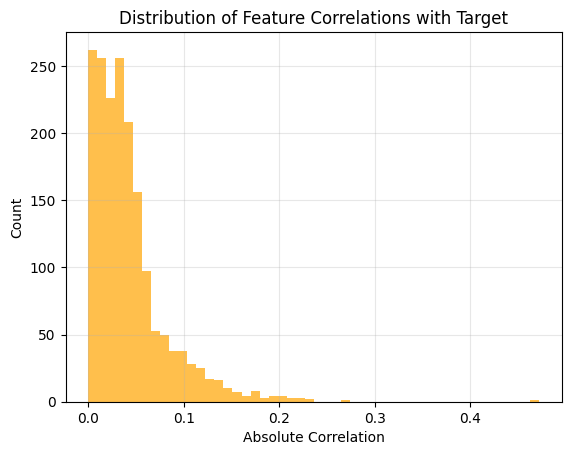

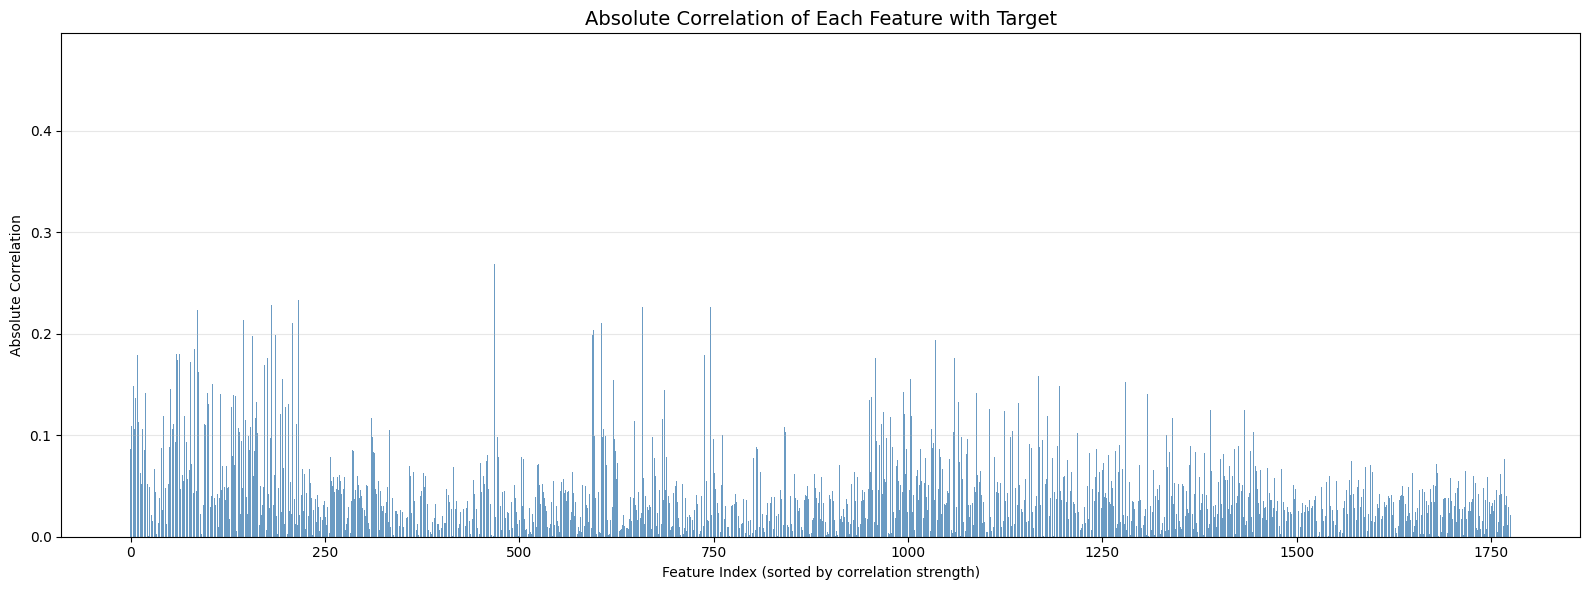

Selected 518 features out of 1776


In [3]:
df.info()

print("\nColumns with missing values or unexpected types")

missing_cols = df.columns[df.isnull().any()].tolist()

non_float_cols = [col for col in df.columns if df[col].dtype != float]

if len(missing_cols) > 0:
    print("\n--- Columns with missing values ---")
    for col in missing_cols:
        print(col, df[col].isnull().sum())
else:
    print("No missing-value columns found.")

if len(non_float_cols) > 0:
    print("\n--- Columns with unexpected types ---")
    for col in non_float_cols:
        print(col, df[col].dtype)
else:
    print("No non-float columns found.")

if 'target' in df.columns:
    unique_vals = df['target'].unique()
    print("Unique values for target:", unique_vals)

    # Count how many 0s and 1s
    value_counts = df['target'].value_counts()
    print("\nCounts per value:")
    for val, count in value_counts.items():
        print(f"  {val}: {count}")

    # Optional: show class balance ratio
    ratio = value_counts / len(df)
    print("\nProportion per value:")
    for val, r in ratio.items():
        print(f"  {val}: {r:.2%}")

summary = pd.DataFrame({
    "min": df.min(numeric_only=True),
    "max": df.max(numeric_only=True)
})

# Reset index to use column names as x-axis
summary = summary.reset_index().rename(columns={'index': 'feature'})

plt.figure(figsize=(14, 6))
plt.plot(summary["feature"], summary["min"], label="Min", alpha=0.7)
plt.plot(summary["feature"], summary["max"], label="Max", alpha=0.7)
plt.title("Min and Max Values per Numeric Column")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.legend()
plt.xticks([], [])  # Hide x labels (too many features)
plt.grid(True, alpha=0.3)
plt.show()


# correlation
corr = df.corr(numeric_only=True)['target'].drop('target')

# Take absolute values (so negative correlation counts too)
corr_abs = corr.abs().sort_values(ascending=False)

# plot
plt.figure(figsize=(16, 6))
plt.bar(range(len(corr_abs)), corr_abs, color='steelblue', alpha=0.8)
plt.title('Absolute Correlation of Each Feature with Target', fontsize=14)
plt.xlabel('Feature Index (sorted by correlation strength)')
plt.ylabel('Absolute Correlation')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# correlation distribution
plt.hist(corr_abs, bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Feature Correlations with Target')
plt.xlabel('Absolute Correlation')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

# plot
plt.figure(figsize=(16, 6))
plt.bar(range(len(corr.abs())), corr.abs(), color='steelblue', alpha=0.8)
plt.title('Absolute Correlation of Each Feature with Target', fontsize=14)
plt.xlabel('Feature Index (sorted by correlation strength)')
plt.ylabel('Absolute Correlation')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


threshold = 0.05
selected_features = corr_abs[corr_abs >= threshold].index

print(f"Selected {len(selected_features)} features out of {len(corr_abs)}")

df_filtered = df[selected_features.tolist() + ['target']]


In [4]:
class DataModule:
    def __init__(self, df_filtered):
        X = df_filtered.iloc[:, :-1].values.astype(np.float32)
        y = df_filtered.iloc[:, -1].values.astype(np.float32).reshape(-1, 1)

        # Step 1: split off test set first
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Step 2: from the remaining 80%, make train/val split
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
        )

        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)

        self.x_train = torch.tensor(X_train)
        self.y_train = torch.tensor(y_train)
        self.x_val = torch.tensor(X_val)
        self.y_val = torch.tensor(y_val)
        self.x_test = torch.tensor(X_test)
        self.y_test = torch.tensor(y_test)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # class imbalance handling
        pos = (y_train == 1).sum()
        neg = (y_train == 0).sum()
        self.pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)

    def setup(self, cfg):
        self.dataloader_train = torch.utils.data.dataloader.DataLoader(
            torch.utils.data.TensorDataset(self.x_train, self.y_train), batch_size=cfg.batch_size,
            shuffle=True, num_workers=cfg.num_workers, pin_memory=True
        )
        self.dataloader_val = torch.utils.data.dataloader.DataLoader(
            torch.utils.data.TensorDataset(self.x_val, self.y_val), batch_size=cfg.batch_size,
            shuffle=False, num_workers=cfg.num_workers, pin_memory=True
        )

In [5]:
class Statistics:
    def __init__(self):
        self.values = dict()

    def step(self, key, value):
        sum, count = 1.0, 1.0
        if key in self.values:
            sum, count = self.values[key]
        sum += value
        count += 1
        self.values[key] = sum, count

    def get(self):
        result = dict()
        for k, (sum, count) in self.values.items():
            result[k] = float(sum / count)
        return result


In [6]:
class MLP(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, p):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden // 2),
            nn.LeakyReLU(),
            nn.Linear(n_hidden // 2, n_hidden // 10),
            nn.ReLU(),
            nn.Linear(n_hidden // 10, 1),
        )

    def forward(self, x):
        return self.main(x)

In [7]:
class Trainer_Batch:
    def __init__(self, cfg, model, loss, optimizer, epochs):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = model.to(self.device)
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.cfg = cfg
        self.history = {"train": [], "val": []}

    def setup(self, datamodule):
        self.datamodule = datamodule
        self.datamodule.setup(self.cfg)

    def train(self, patience=10):

        # get all data at once
        x_train, y_train = self.datamodule.x_train.to(self.device), self.datamodule.y_train.to(self.device)
        x_val, y_val = self.datamodule.x_val.to(self.device), self.datamodule.y_val.to(self.device)

        for epoch in range(self.epochs):
            stats = Statistics()

            # training
            self.model.train()
            # with tqdm(self.datamodule.dataloader_train, desc=f"Train: {epoch}") as progress:
            for x_train, y_train in self.datamodule.dataloader_val:#progress:
                x_train = x_train.to(self.device)
                y_train = y_train.to(self.device)

                logits = self.model(x_train)
                l = self.loss(logits, y_train)

                self.optimizer.zero_grad()
                l.backward()
                self.optimizer.step()

                stats.step("loss_train", l.item())
                    # progress.set_postfix(stats.get())

            # validating
            self.model.eval()
            with torch.no_grad():
                # with tqdm(self.datamodule.dataloader_val, desc=f"Val: {epoch}") as progress:
                for x_val, y_val in self.datamodule.dataloader_val:#progress:
                    x_val = x_val.to(self.device)
                    y_val = y_val.to(self.device)

                    logits = self.model(x_val)
                    l = self.loss(logits, y_val)

                    stats.step("loss_val", l.item())
                        # progress.set_postfix(stats.get())

            # store for plotting
            self.history["train"].append(stats.get()["loss_train"])
            self.history["val"].append(stats.get()["loss_val"])


        # plt.figure(figsize=(8,5))
        # plt.plot(self.history["train"], label="Training Loss")
        # plt.plot(self.history["val"], label="Validation Loss")
        # plt.xlabel("Epoch")
        # plt.ylabel("Loss")
        # plt.title("Training vs Validation Loss")
        # plt.legend()
        # plt.grid(True)
        # plt.show()

In [10]:
class Trainer_noBatch:
    def __init__(self, cfg, model, loss, optimizer, epochs):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = model.to(self.device)
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.cfg = cfg
        self.history = {"train": [], "val": []}

    def setup(self, datamodule):
        self.datamodule = datamodule
        self.datamodule.setup(self.cfg)

    def train(self, patience=10):

        # get all data at once
        x_train, y_train = self.datamodule.x_train.to(self.device), self.datamodule.y_train.to(self.device)
        x_val, y_val = self.datamodule.x_val.to(self.device), self.datamodule.y_val.to(self.device)

        for epoch in range(self.epochs):
            stats = Statistics()

            # training
            self.model.train()
            logits = self.model(x_train)
            l = self.loss(logits, y_train)

            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()

            stats.step("loss_train", l.item())

            # validating
            self.model.eval()
            with torch.no_grad():
                logits = self.model(x_val)
                l = self.loss(logits, y_val)

                stats.step("loss_val", l.item())

            # store for plotting
            self.history["train"].append(stats.get()["loss_train"])
            self.history["val"].append(stats.get()["loss_val"])

        # plt.figure(figsize=(8,5))
        # plt.plot(self.history["train"], label="Training Loss")
        # plt.plot(self.history["val"], label="Validation Loss")
        # plt.xlabel("Epoch")
        # plt.ylabel("Loss")
        # plt.title("Training vs Validation Loss")
        # plt.legend()
        # plt.grid(True)
        # plt.show()

In [12]:
sweep_config = {
    "method": "grid",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"value": 40},
        "num_workers": {"value": 0},
        "lr": {
            "values": [1e-5, 1e-4, 1e-3, 1e-2]
        },
        "weight_decay": {
            "values": [0.0, 0.0001, 0.001]
        },
        "num_hidden": {
            "values": [64, 128, 256]
        },
        "batch_size": {
            "values": [32, 64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="ZNEUS")
def train_sweep():
    wandb.init()
    cfg = wandb.config

    datamodule = DataModule(df_filtered)

    n_in = datamodule.x_train.shape[1]

    model = MLP(n_in, n_hidden=cfg.num_hidden, n_out=1, p=0.5)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    trainer = Trainer_Batch(cfg, model,
                       loss=torch.nn.BCEWithLogitsLoss(pos_weight=datamodule.pos_weight),
                       optimizer=optimizer,
                       epochs=cfg.epochs)
    trainer.setup(datamodule)
    trainer.train()

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        logits = model(datamodule.x_test.to(device))
        y_pred = torch.sigmoid(logits)
        y_pred_labels = (y_pred > 0.5).float()

        test_loss = trainer.loss(logits, datamodule.y_test.to(device))
        acc = (y_pred_labels == datamodule.y_test.to(device)).float().mean()

    # Log final metrics
    wandb.log({
        "final_test_loss": test_loss.item(),
        "final_test_acc": acc.item()
    })

wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: utgtlpvx
Sweep URL: https://wandb.ai/picklemasters/ZNEUS/sweeps/utgtlpvx


wandb: Agent Starting Run: qpo1atzj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.53395
final_test_loss,0.627


wandb: Agent Starting Run: 43c0j1og with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.5526
final_test_loss,0.62989


wandb: Agent Starting Run: n705j94e with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.45806
final_test_loss,0.62566


wandb: Agent Starting Run: 7ewjuikq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.5486
final_test_loss,0.61115


wandb: Agent Starting Run: 6gy5r4w3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.63782
final_test_loss,0.61081


wandb: Agent Starting Run: b7qu4r32 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.55792
final_test_loss,0.61672


wandb: Agent Starting Run: 5f4jwd6g with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.68842
final_test_loss,0.5897


wandb: Agent Starting Run: 40tunean with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7004
final_test_loss,0.58088


wandb: Agent Starting Run: mkc4jufy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.68309
final_test_loss,0.58307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x0nrves2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.74035
final_test_loss,0.51238


wandb: Agent Starting Run: jfylgtqy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73901
final_test_loss,0.54492


wandb: Agent Starting Run: ck0vu19u with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.75499
final_test_loss,0.4978


wandb: Agent Starting Run: j6ibzhmh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71238
final_test_loss,0.66972


wandb: Agent Starting Run: 98uhyt1k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73768
final_test_loss,0.67692


wandb: Agent Starting Run: jtx0bwjd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73236
final_test_loss,0.68286


wandb: Agent Starting Run: hefk7coy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7257
final_test_loss,1.03816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jgi4eb09 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,0.96509


wandb: Agent Starting Run: 79xis0zn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,0.99747


wandb: Agent Starting Run: 4jh6n19y with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,1.82825


wandb: Agent Starting Run: he7a17ac with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70706
final_test_loss,1.71058


wandb: Agent Starting Run: yes7628n with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70573
final_test_loss,1.52748


wandb: Agent Starting Run: 71s24po1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70706
final_test_loss,1.93602


wandb: Agent Starting Run: twf0036m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70706
final_test_loss,1.91127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wot3f870 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71238
final_test_loss,1.59237


wandb: Agent Starting Run: ejrkxhmx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,2.26413


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rto4mwk0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71105
final_test_loss,2.64987


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8e13z5jj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70839
final_test_loss,1.47471


wandb: Agent Starting Run: 5007yn1k with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,3.50915


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6f8dfi5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7004
final_test_loss,1.42518


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05ab0anj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70972
final_test_loss,1.07182


wandb: Agent Starting Run: 5v6vq1r8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.6964
final_test_loss,4.57403


wandb: Agent Starting Run: k1qtu5e3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72037
final_test_loss,3.08717


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7aqfihyd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71638
final_test_loss,1.5146


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hd5uwg4l with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70839
final_test_loss,4.14883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6wo5erjk with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.69774
final_test_loss,2.38667


wandb: Agent Starting Run: saslhjjm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,1.30844


wandb: Agent Starting Run: ypuam690 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.45806
final_test_loss,0.63402


wandb: Agent Starting Run: 9i2n6x7j with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.45806
final_test_loss,0.62854


wandb: Agent Starting Run: kncflciy with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.63648
final_test_loss,0.62697


wandb: Agent Starting Run: of69hgdw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.65246
final_test_loss,0.61495


wandb: Agent Starting Run: n0m1eqkt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.63648
final_test_loss,0.61837


wandb: Agent Starting Run: 8b9w4tqy with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.57656
final_test_loss,0.62416


wandb: Agent Starting Run: kqu03yfz with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.66977
final_test_loss,0.59798


wandb: Agent Starting Run: 5bdr6idb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.63249
final_test_loss,0.60631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4yjcxge with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.56591
final_test_loss,0.60897


wandb: Agent Starting Run: 8v8aetq9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71638
final_test_loss,0.50965


wandb: Agent Starting Run: igeats8i with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72836
final_test_loss,0.50772


wandb: Agent Starting Run: u416lroh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73901
final_test_loss,0.5062


wandb: Agent Starting Run: qvgpi8ls with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73369
final_test_loss,0.54056


wandb: Agent Starting Run: 5rqbna0i with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.74035
final_test_loss,0.50767


wandb: Agent Starting Run: 0pavkuvh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.74434
final_test_loss,0.51315


wandb: Agent Starting Run: 7ymikfkp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72969
final_test_loss,0.70679


wandb: Agent Starting Run: 6lud5pfo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7217
final_test_loss,0.66592


wandb: Agent Starting Run: lkgm7w3t with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73901
final_test_loss,0.70089


wandb: Agent Starting Run: ew7h58ib with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70706
final_test_loss,1.56959


wandb: Agent Starting Run: bsdkgm9n with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71638
final_test_loss,1.58142


wandb: Agent Starting Run: ccz2rtu1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70706
final_test_loss,1.07877


wandb: Agent Starting Run: kd8kmptp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71771
final_test_loss,1.80577


wandb: Agent Starting Run: z06ok8xp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,1.67742


wandb: Agent Starting Run: w3c73kat with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71638
final_test_loss,1.38156


wandb: Agent Starting Run: pxvgemo8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,2.11457


wandb: Agent Starting Run: y820kflo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,1.9329


wandb: Agent Starting Run: g0irut6z with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71904
final_test_loss,1.31292


wandb: Agent Starting Run: bnec2bj2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.69774
final_test_loss,3.39565


wandb: Agent Starting Run: i6wo65or with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,3.13586


wandb: Agent Starting Run: vy9v4trm with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.68842
final_test_loss,2.0823


wandb: Agent Starting Run: 2xilb9ct with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71372
final_test_loss,3.24614


wandb: Agent Starting Run: 0gvmk7cr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,2.89598


wandb: Agent Starting Run: 99s9isdx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,1.7139


wandb: Agent Starting Run: m3rb7z6y with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7004
final_test_loss,4.88444


wandb: Agent Starting Run: d3yxwb9m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71372
final_test_loss,3.01839


wandb: Agent Starting Run: mj42eo4e with config:
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.69907
final_test_loss,1.47461


wandb: Agent Starting Run: 8ulzxr3m with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.54328
final_test_loss,0.63569


wandb: Agent Starting Run: kmy79nu2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.54194
final_test_loss,0.64844


wandb: Agent Starting Run: 26drm3eq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.54328
final_test_loss,0.63088


wandb: Agent Starting Run: 91ybuwsf with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.54328
final_test_loss,0.63087


wandb: Agent Starting Run: 1eefzjyz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.58988
final_test_loss,0.62688


wandb: Agent Starting Run: l997cqgx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.54194
final_test_loss,0.63759


wandb: Agent Starting Run: 8fblslae with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.60053
final_test_loss,0.62013


wandb: Agent Starting Run: pq6us7qu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.46738
final_test_loss,0.6242


wandb: Agent Starting Run: 6270j6b0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 1e-05
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.62983
final_test_loss,0.62028


wandb: Agent Starting Run: 09nubohe with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,0.55455


wandb: Agent Starting Run: e8vjkina with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73502
final_test_loss,0.55488


wandb: Agent Starting Run: mvgfcxv9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.64581
final_test_loss,0.55766


wandb: Agent Starting Run: yg0t78xf with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72703
final_test_loss,0.50247


wandb: Agent Starting Run: hiz8kxia with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72836
final_test_loss,0.49713


wandb: Agent Starting Run: pq5a6ss5 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72969
final_test_loss,0.49853


wandb: Agent Starting Run: zi8wl60o with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.747
final_test_loss,0.52281


wandb: Agent Starting Run: zrmbyaq3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72969
final_test_loss,0.52378


wandb: Agent Starting Run: hfczwbtk with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.0001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72703
final_test_loss,0.52264


wandb: Agent Starting Run: h1x4zct0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,1.37385


wandb: Agent Starting Run: f103tdbs with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70972
final_test_loss,1.2344


wandb: Agent Starting Run: pn5lhhhx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71771
final_test_loss,1.23053


wandb: Agent Starting Run: vhgwlntd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.7257
final_test_loss,1.66344


wandb: Agent Starting Run: ouvk5jxw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71505
final_test_loss,1.75922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xs1rnkrz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70972
final_test_loss,1.28421


wandb: Agent Starting Run: vpvhv5te with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71372
final_test_loss,1.87157


wandb: Agent Starting Run: n8nyrkid with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71638
final_test_loss,1.73932


wandb: Agent Starting Run: 375mr2rm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.001
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.71372
final_test_loss,1.4258


wandb: Agent Starting Run: j5xyzgwl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.6964
final_test_loss,3.37408


wandb: Agent Starting Run: kvlb63si with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.72304
final_test_loss,1.21132


wandb: Agent Starting Run: w6415jpl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 64
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70972
final_test_loss,1.65144


wandb: Agent Starting Run: ep4ri028 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70573
final_test_loss,3.73789


wandb: Agent Starting Run: 7ymej5hl with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.73236
final_test_loss,3.41286


wandb: Agent Starting Run: pxb7gsdo with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 128
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,1.78863


wandb: Agent Starting Run: rgjs1byd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.69108
final_test_loss,4.51128


wandb: Agent Starting Run: 1h91wbmc with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.0001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70439
final_test_loss,2.98449


wandb: Agent Starting Run: 6wjh0usy with config:
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	lr: 0.01
wandb: 	num_hidden: 256
wandb: 	num_workers: 0
wandb: 	weight_decay: 0.001


final_test_acc,▁
final_test_loss,▁
final_test_acc,0.70173
final_test_loss,1.80134


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
